In [1]:
import numpy as np
import matplotlib.pyplot as plt

from stacked_mnist import StackedMNISTData, DataMode
from models.auto_encoder import AutoEncoder
from models.mnist_classifier import MNISTClassifier

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from utils import *

In [2]:
model = AutoEncoder(in_channels=3)
model.load_state_dict(torch.load('trained_models/auto_encoder_rgb.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [3]:
# Get latent variable
# Using the provided mnist dataset class
gen = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE, default_batch_size=9)
test_data = gen.get_full_data_set(training=False)

x_test, y_test = test_data

# Convert y_train and y_test into one-hot vectors
y_test = to_one_hot_rgb(y_test)

# Create pytorch dataloaders from x_test and y_test
x_test = torch.from_numpy(x_test.astype(np.float32)).permute(0, 3, 1, 2)
y_test = torch.from_numpy(y_test.astype(np.float32))

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(dataset=test_dataset, batch_size=32)

images, _ = next(iter(test_loader))
latent = model.encoder(images)

mean = latent.mean(dim=0)
std = (latent-mean).pow(2).mean(dim=0).sqrt()

z = torch.randn(32, 16) * std + mean

z

tensor([[-2.1873e+00,  1.9784e+00,  8.4675e-02,  3.2412e+00, -3.4256e-02,
          1.1010e+00, -3.1095e+00, -1.6832e+00,  1.0813e+00, -3.0606e+00,
          2.0791e+00, -4.2051e-01, -5.6889e-01, -1.3044e+00,  4.6590e+00,
         -3.0838e+00],
        [-1.9293e+00,  5.9016e-01,  1.4379e+00,  1.0710e+00,  1.8132e+00,
          6.0668e-01, -3.0291e+00,  2.2384e-01,  1.4894e-02, -4.7057e+00,
         -3.6190e+00, -5.4825e-01, -5.1255e-02, -5.6640e-01, -9.4537e-01,
         -5.4754e-01],
        [-4.0346e+00,  3.4902e+00,  2.8711e+00,  1.6029e+00, -1.9069e+00,
         -1.0828e+00, -2.5993e+00,  1.2140e+00, -4.9311e-02, -2.4358e+00,
         -3.3228e-01,  1.1169e+00, -1.1633e+00,  9.5444e-01,  2.1507e+00,
         -1.1127e+00],
        [-3.9143e+00,  1.2031e-01, -1.3705e+00,  3.7194e+00, -6.4611e-01,
         -1.1344e+00, -2.6907e-01, -2.2743e+00,  6.6596e-01, -1.6856e+00,
         -4.6292e+00,  1.9752e+00,  1.0046e-02, -8.7058e-01, -3.0361e-02,
          5.7145e-01],
        [-4.6914e+00

In [4]:
model.eval()
with torch.no_grad():
    generated_images = model.decoder(z)

In [5]:
generated_images.shape

torch.Size([32, 3, 28, 28])

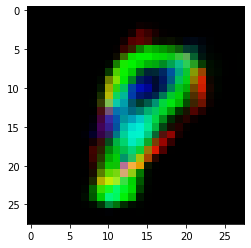

In [6]:
plt.imshow(generated_images[0].permute(1, 2, 0))

In [7]:
model

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=512, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=(128, 2, 2))
    (5): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (6): ReLU()
    (7): ConvTranspose2d(64, 32, kernel_size=(3, 3)

In [8]:
z = model.decoder[0:5](z)

c1 = model.decoder[5](z)
c1 = F.relu(c1)

c2 = model.decoder[7](c1)
c2 = F.relu(c2)

c3 = model.decoder[9](c2)
c3 = F.relu(c3)


c4 = model.decoder[11](c3)


c1.shape, c2.shape, c3.shape, c4.shape


(torch.Size([32, 64, 4, 4]),
 torch.Size([32, 32, 7, 7]),
 torch.Size([32, 16, 14, 14]),
 torch.Size([32, 3, 28, 28]))

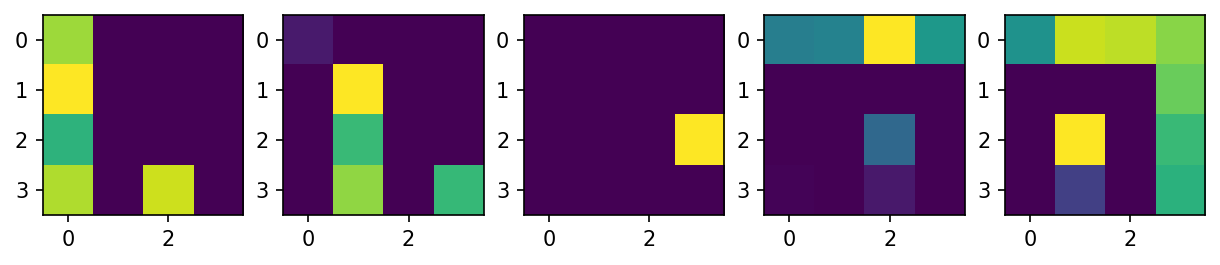

In [9]:
# Visualize som feature maps from c1
with torch.no_grad():
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(1, 5, figsize=(10, 6), dpi=150)

    # Plot each image in a separate subplot
    for i in range(5):
        axs[i].imshow(c1[0][i])
        
    plt.show()

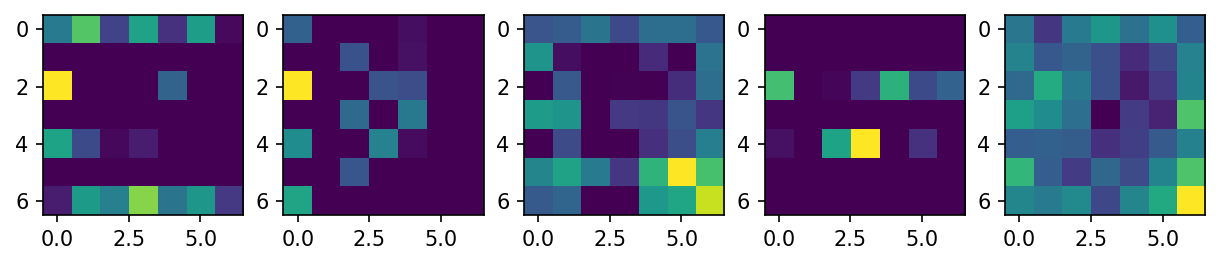

In [10]:
with torch.no_grad():
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(1, 5, figsize=(10, 6), dpi=150)

    # Plot each image in a separate subplot
    for i in range(5):
        axs[i].imshow(c2[0][i])
        
    plt.show()

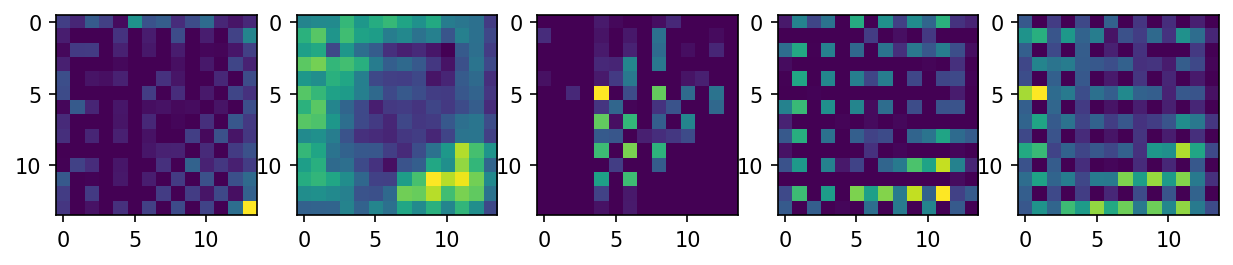

In [11]:
with torch.no_grad():
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(1, 5, figsize=(10, 6), dpi=150)

    # Plot each image in a separate subplot
    for i in range(5):
        axs[i].imshow(c3[0][i])
        
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\mikke\AppData\Roaming\Python\Python39\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


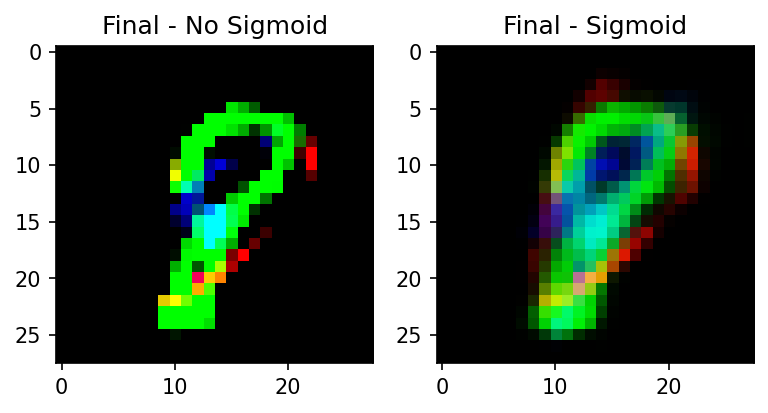

In [12]:
with torch.no_grad():    
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(1, 2, figsize=(6, 4), dpi=150)

    # Plot each image in a separate subplot
    axs[0].imshow(c4[0].squeeze(0).permute(1, 2, 0))
    axs[0].set_title('Final - No Sigmoid')
    axs[1].imshow(F.sigmoid(c4[0].permute(1, 2, 0)))
    axs[1].set_title('Final - Sigmoid')

        
    plt.show()
    

Some more generated images

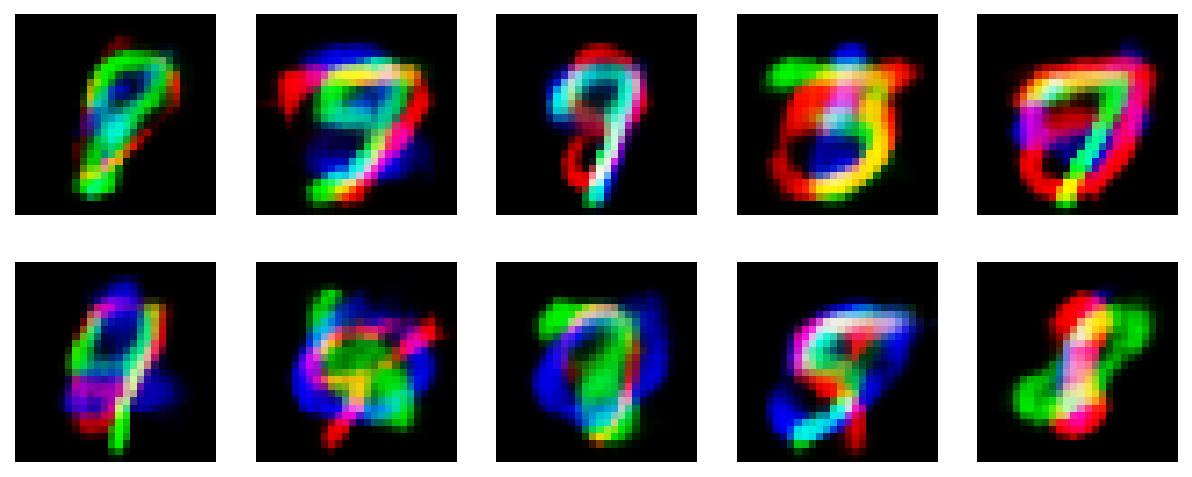

In [13]:
with torch.no_grad():    
    # Create a figure with 5 horizontally arranged subplots
    fig, axs = plt.subplots(2, 5, figsize=(10, 4), dpi=150)

    n = 0
    for i in range(2):
        for j in range(5):
            axs[i, j].imshow(generated_images[n].permute(1, 2, 0))
            axs[i, j].axis("off")
            n += 1

        
    plt.show()